### 19. Segmentation of 3D lung CTs using MONAI and Elastix

This notebook uses the MONAI code and pretrained model from the following tutorial https://github.com/Project-MONAI/tutorials/blob/main/3d_registration/paired_lung_ct.ipynb. It further refines the segmentation achieved using the deep learning model by a second lon-linear registration with Elastix.

In [1]:
import os, copy
import matplotlib.pyplot as plt
import numpy as np
import torch
import itk
import itk_torch_ddf_bridge as itk_bridge
from monai.apps import download_url, download_and_extract
from monai.data import DataLoader, Dataset, CacheDataset
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import LocalNet
from monai.transforms import (
    Compose,
    LoadImaged,
    Resized,
    ScaleIntensityRanged,
)
from monai.utils import set_determinism


set_determinism(42)
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print("Device: ", device)

C:\Users\kntatsis\monai-weekly-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda:0


### Dataset

Download and extract the dataset

In [2]:
root_dir = './'
resource = "https://zenodo.org/record/3835682/files/training.zip"

compressed_file = os.path.join(root_dir, "paired_ct_lung.zip")
data_dir = os.path.join(root_dir, "paired_ct_lung")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)
    os.rename(os.path.join(root_dir, "training"), data_dir)

Split in training and validation

In [3]:
data_dicts = [
    {
        "fixed_image": os.path.join(data_dir, "scans/case_%03d_exp.nii.gz" % idx),
        "moving_image": os.path.join(data_dir, "scans/case_%03d_insp.nii.gz" % idx),
        "fixed_label": os.path.join(data_dir, "lungMasks/case_%03d_exp.nii.gz" % idx),
        "moving_label": os.path.join(data_dir, "lungMasks/case_%03d_insp.nii.gz" % idx),
    }
    for idx in range(1, 21)
]

train_files, val_files = data_dicts[:18], data_dicts[18:]

Since we are going to use the pretrained model, we are interested only for the validation transforms

In [4]:
val_transforms = Compose(
    [
        LoadImaged(keys=["fixed_image", "moving_image", "fixed_label", "moving_label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285,
            a_max=3770,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=("trilinear", "trilinear", "nearest", "nearest"),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104),
        ),
    ]
)

Setup the MONAI dataset and dataloader

In [5]:
val_dataset = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=4)

Loading dataset: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:04<00:00,  2.48s/it]


### MONAI model with pre-trained weights

In [6]:
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[3],
    out_activation=None,
    out_kernel_initializer="zeros",
).to(device)
warp_layer = Warp().to(device)

monai.networks.blocks.Warp: Using PyTorch native grid_sample.


In [7]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/pair_lung_ct.pth"
dst = f"{root_dir}/pretrained_weight.pth"
download_url(resource, dst)
model.load_state_dict(torch.load(dst))
model.eval();

2023-02-09 17:32:18,696 - INFO - Expected md5 is None, skip md5 check for file pretrained_weight.pth.
2023-02-09 17:32:18,696 - INFO - File exists: pretrained_weight.pth, skipped downloading.


In [8]:
with torch.no_grad():
    data = next(iter(val_dataloader))
    
    # Move images to device
    fixed_image = data["fixed_image"].to(device)
    fixed_label = data["fixed_label"].to(device)
    moving_image = data["moving_image"].to(device)
    moving_label = data["moving_label"].to(device)

    # Predict DDF through LocalNet
    ddf = model(torch.cat((moving_image, fixed_image), dim=1))

    # Warp moving image and label with the predicted ddf
    predicted_image_monai = warp_layer(moving_image, ddf)
    predicted_label_monai = warp_layer(moving_label, ddf)
    
    # Convert label to [0, 1] and uint 
    predicted_label_monai = (predicted_label_monai > 0.5).to(torch.uint8)
           
    ddf = ddf.squeeze().cpu().numpy()

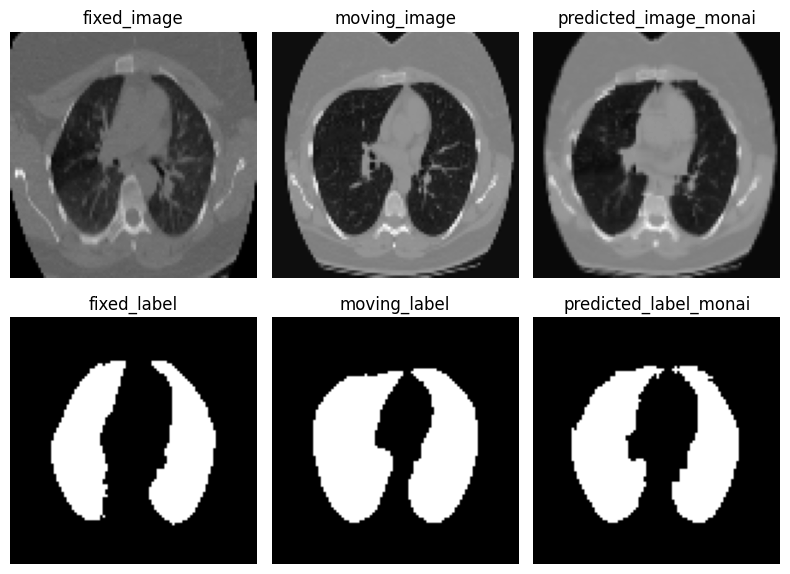

In [9]:
image_list = ["fixed_image", "fixed_label", "moving_image", "moving_label", "predicted_image_monai", "predicted_label_monai"]

# Move all images from device to cpu and numpy
_to_array =  lambda x : x.squeeze().cpu().numpy()
for img in image_list:
    exec(f"{img} = _to_array({img})")

# Create a dictionary of the images for ease of visualization
image_dict = {img: eval(img) for img in image_list}

def visualize_images(image_dict):
    keys = list(image_dict.keys())
    keys = keys[::2] + keys[1::2] # re-arrange images vs labels
    central_slice = 52
    plt.figure(figsize=(8, 6))
    for i, key in enumerate(keys):
        plt.subplot(2, len(keys)//2, i+1)
        plt.title(key)
        plt.imshow(image_dict[key].transpose(1, 0, 2)[:, :, central_slice], cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
                    
visualize_images(image_dict)

### Resample using ITK (to be replaced when SetInitialTransform() is supported)

In [10]:
fixed_image_itk = itk.GetImageFromArray(fixed_image)
moving_image_itk = itk.GetImageFromArray(moving_image)
fixed_label_itk = itk.GetImageFromArray(fixed_label)
moving_label_itk = itk.GetImageFromArray(moving_label)

displacement_field = itk_bridge.monai_to_itk_ddf(moving_image_itk, ddf)

# Resample the moving image using the ddf 
linear_interpolator = itk.LinearInterpolateImageFunction.New(moving_image_itk)
predicted_image_monai_itk = itk.warp_image_filter(moving_image_itk,
                                   interpolator=linear_interpolator,
                                   displacement_field=displacement_field,
                                   output_parameters_from_image=moving_image)
predicted_image_monai_itk = itk.GetImageFromArray(predicted_image_monai_itk)

# Resample the label using the ddf
nearest_interpolator = itk.NearestNeighborInterpolateImageFunction.New(moving_label_itk)
predicted_label_monai_itk = itk.warp_image_filter(moving_label_itk,
                                   interpolator=nearest_interpolator,
                                   displacement_field=displacement_field,
                                   output_parameters_from_image=moving_label_itk)
predicted_label_monai_itk = itk.GetImageFromArray(predicted_label_monai_itk)

### Refine using Elastix

First, create a mask for the fixed image since it is cropped compared to the moving

In [11]:
fixed_mask = copy.deepcopy(fixed_image)
fixed_mask[fixed_mask > 1.05*fixed_image.min()] = 255 
fixed_mask[fixed_mask <= 1.05*fixed_image.min()] = 0 
fixed_mask = fixed_mask.astype(np.uint8)
fixed_mask_itk = itk.GetImageFromArray(fixed_mask)

In [12]:
parameter_object = itk.ParameterObject()
bspline_parameter_map = parameter_object.GetDefaultParameterMap('bspline', 1, 6.0)

parameter_object.AddParameterMap(bspline_parameter_map)

predicted_image_elastix_itk, predicted_transform_parameters = itk.elastix_registration_method(fixed_image_itk, 
                                                                                          predicted_image_monai_itk,
                                                                                          fixed_mask=fixed_mask_itk,
                                                                                          parameter_object=parameter_object,
                                                                                          log_to_console=False)
predicted_image_elastix = np.asarray(predicted_image_elastix_itk)

In [13]:
# Change interpolation mode to nearest
predicted_transform_parameters.SetParameter(0, "FinalBSplineInterpolationOrder", "0")

# Transform the label
transformix_object = itk.TransformixFilter.New(predicted_label_monai_itk)
transformix_object.SetTransformParameterObject(predicted_transform_parameters)
transformix_object.SetLogToConsole(False)
transformix_object.UpdateLargestPossibleRegion()

predicted_label_elastix_itk = transformix_object.GetOutput()
predicted_label_elastix = np.asarray(predicted_label_elastix_itk)

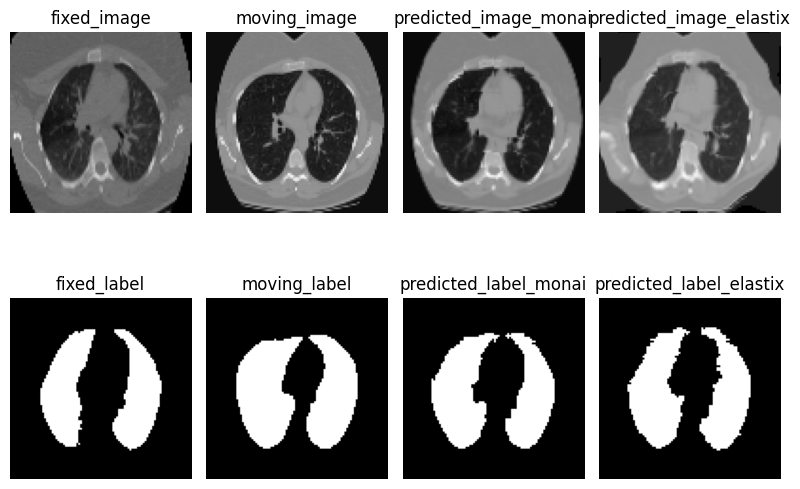

In [14]:
# Append to image dictionary that keeps the results
image_dict["predicted_image_elastix"] = predicted_image_elastix
image_dict["predicted_label_elastix"] = predicted_label_elastix

visualize_images(image_dict)

### Compare the dice score on the labels

In [15]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

_to_tensor = lambda x: torch.tensor(np.asarray(x)).unsqueeze(0).unsqueeze(0)
print("Dice moving: ", dice_metric(_to_tensor(moving_label), _to_tensor(fixed_label)).item())
print("Dice monai: ", dice_metric(_to_tensor(predicted_label_monai), _to_tensor(fixed_label)).item())
print("Dice monai+elastix: ", dice_metric(_to_tensor(predicted_label_elastix), _to_tensor(fixed_label)).item())

Dice moving:  0.7347397208213806
Dice monai:  0.88922518491745
Dice monai+elastix:  0.9077429175376892


In [16]:
# Possible TODOs:
# 1. Calculate spatial jacobian
# 2. Change of volumes between insp, exp
# 3. Take original metadata into account (note the images are getting resized during preprocessing)